In [115]:
import os
import shutil
from sklearn.model_selection import train_test_split
from collections import Counter

# Paths - update these as needed
dataset_dir = r"C:\Users\user\OneDrive - University of Hertfordshire\project\Dataset\chest_xray"
output_dir = r"C:\Users\user\OneDrive - University of Hertfordshire\project\Dataset_splitted"

# Step 1: Gather all image paths and labels from the original train folder
image_paths = []
labels = []

for label_name in ['NORMAL', 'PNEUMONIA']:
    class_dir = os.path.join(dataset_dir, 'train', label_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(0 if label_name == 'NORMAL' else 1)

print(f"Total images found in original train folder: {len(image_paths)}")
print(f"Class distribution: {Counter(labels)}")

# Step 2: Split into train_val (85%) and test (15%)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.15, stratify=labels, random_state=42)

# Step 3: Split train_val into train (85% of train_val) and val (15% of train_val)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.15, stratify=train_val_labels, random_state=42)

# Step 4: Create directory structure for splits
for split in ['train', 'val', 'test']:
    for label in ['NORMAL', 'PNEUMONIA']:
        os.makedirs(os.path.join(output_dir, split, label), exist_ok=True)

# Step 5: Copy images to their respective folders
def save_images(paths, labels, split_name):
    for path, label in zip(paths, labels):
        label_str = 'NORMAL' if label == 0 else 'PNEUMONIA'
        dest_dir = os.path.join(output_dir, split_name, label_str)
        shutil.copy2(path, dest_dir)

save_images(train_paths, train_labels, 'train')
save_images(val_paths, val_labels, 'val')
save_images(test_paths, test_labels, 'test')

# Step 6: Print summary statistics
total = len(image_paths)
print("\nImage splitting complete!\n")
print(f"Train split: {len(train_paths)} images ({len(train_paths)/total*100:.2f}%) - {Counter(train_labels)}")
print(f"Validation split: {len(val_paths)} images ({len(val_paths)/total*100:.2f}%) - {Counter(val_labels)}")
print(f"Test split: {len(test_paths)} images ({len(test_paths)/total*100:.2f}%) - {Counter(test_labels)}")


Total images found in original train folder: 5232
Class distribution: Counter({1: 3883, 0: 1349})

Image splitting complete!

Train split: 3779 images (72.23%) - Counter({1: 2804, 0: 975})
Validation split: 668 images (12.77%) - Counter({1: 496, 0: 172})
Test split: 785 images (15.00%) - Counter({1: 583, 0: 202})



 TRAIN SET 
NORMAL: 975 images


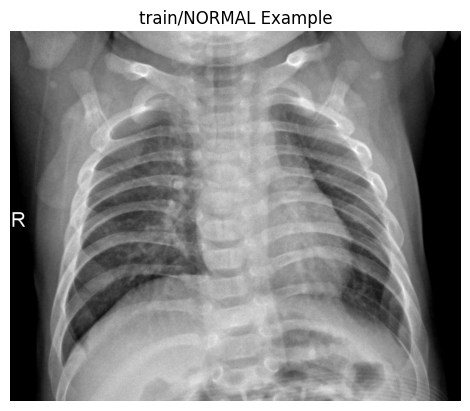

PNEUMONIA: 2804 images


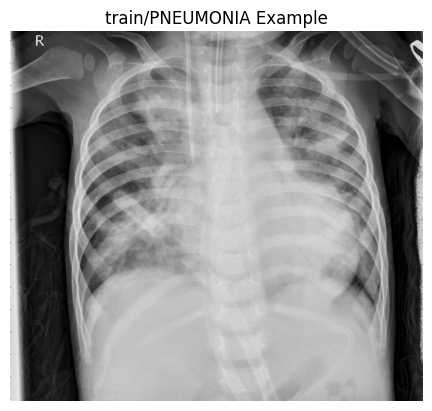

Total images in train: 3779

 VAL SET 
NORMAL: 172 images


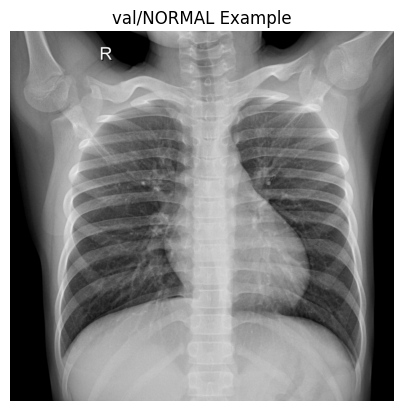

PNEUMONIA: 496 images


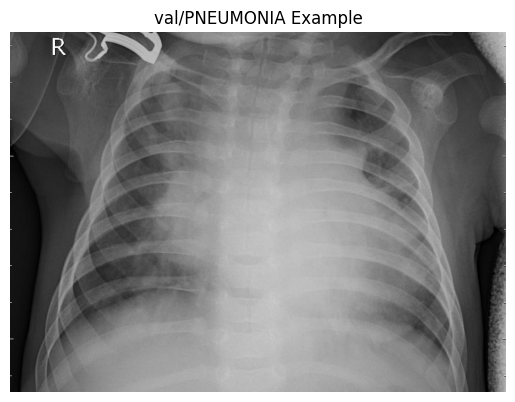

Total images in val: 668

 TEST SET 
NORMAL: 202 images


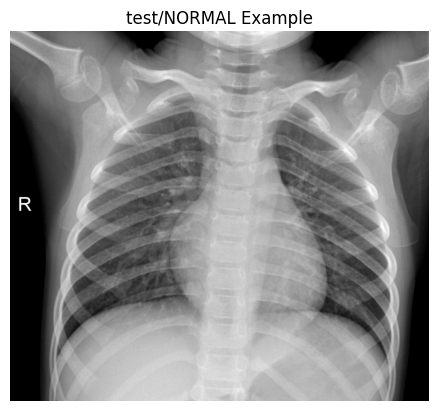

PNEUMONIA: 583 images


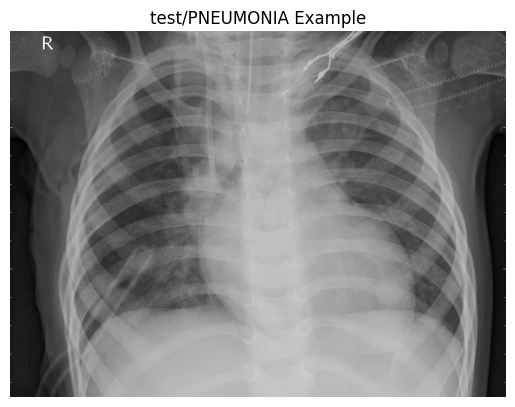

Total images in test: 785

 GRAND TOTAL: 5232 images 


In [104]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Base directory of dataset
base_dir = r'C:\Users\user\OneDrive - University of Hertfordshire\project\Dataset_splitted'
sets = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

# Track grand total
grand_total = 0

# Loop through each set
for set_name in sets:
    print(f"\n {set_name.upper()} SET ")
    total_images = 0

    for cls in classes:
        folder = os.path.join(base_dir, set_name, cls)
        images = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        count = len(images)
        total_images += count
        print(f"{cls}: {count} images")

        # Show only 1 image from each class
        if images:
            img_path = os.path.join(folder, images[0])
            img = Image.open(img_path)
            plt.imshow(img, cmap='gray')
            plt.title(f"{set_name}/{cls} Example")
            plt.axis('off')
            plt.show()

    print(f"Total images in {set_name}: {total_images}")
    grand_total += total_images

# Grand total
print(f"\n GRAND TOTAL: {grand_total} images ")


In [117]:
import os
import random
from PIL import Image, ImageOps
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms.functional as TF


# 1. Preprocessing

def custom_preprocess(img):
    img = ImageOps.equalize(img)       # Histogram Equalization
    img = img.convert('RGB')           # Grayscale to RGB
    img = img.resize((224, 224))       # Resize to match ResNet input
    return img


# 2. Augmentation Function (Random)

def custom_augment(img):
    # Horizontal flip
    if random.random() > 0.5:
        img = TF.hflip(img)

    # Random rotation
    angle = random.uniform(-10, 10)
    img = TF.rotate(img, angle)

    # Safe random crop (only if image is large enough after rotation)
    if img.width < 200 or img.height < 200:
        img = img.resize((224, 224))
    else:
        top, left, height, width = transforms.RandomCrop.get_params(img, output_size=(200, 200))
        img = TF.crop(img, top, left, height, width)
        img = img.resize((224, 224))

    # Add Gaussian noise
    img_np = np.array(img).astype(np.float32) / 255.0
    noise = np.random.normal(0, 0.01, img_np.shape)
    img_np = np.clip(img_np + noise, 0, 1) * 255
    img = Image.fromarray(img_np.astype(np.uint8))

    return img


# 3. Custom Dataset Wrapper

class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None, augment=False):
        super().__init__(root)
        self.transform = transform
        self.augment = augment

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        img = custom_preprocess(img)

        if self.augment:
            img = custom_augment(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target


# 4. Transform Pipeline

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


# 5. Dataset & Dataloader Setup

base_path = r'C:\Users\user\OneDrive - University of Hertfordshire\project\Dataset_splitted'

train_dataset = CustomImageFolder(os.path.join(base_path, 'train'), transform=transform, augment=True)
val_dataset   = CustomImageFolder(os.path.join(base_path, 'val'), transform=transform, augment=False)
test_dataset  = CustomImageFolder(os.path.join(base_path, 'test'), transform=transform, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")


Number of training images: 3779
Number of validation images: 668
Number of test images: 785


In [118]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet50
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Replace final fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Output raw logits

# Unfreeze last convolutional block (layer4) and the final FC layer
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

model = model.to(device)

# Define pos_weight for imbalanced dataset
pos_weight = torch.tensor([0.35], dtype=torch.float).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Set optimizer to update only parameters that require gradients
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

print("Parameters to be trained:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,} ({total_params/1e6:.2f}M)")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/1e6:.2f}M)")


Parameters to be trained:
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.conv3.weight
layer4.0.bn3.weight
layer4.0.bn3.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
layer4.1.conv3.weight
layer4.1.bn3.weight
layer4.1.bn3.bias
layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
layer4.2.conv3.weight
layer4.2.bn3.weight
layer4.2.bn3.bias
fc.weight
fc.bias

Total parameters: 23,510,081 (23.51M)
Trainable parameters: 14,966,785 (14.97M)


In [111]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

def compute_metrics(labels, preds, probs):
    """Compute binary classification metrics safely."""
    return {
        'acc': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f1': f1_score(labels, preds, zero_division=0),
        'auc': roc_auc_score(labels, probs) if len(set(labels)) > 1 else float('nan')
    }

def train_model_with_metrics_and_early_stopping(
    model, criterion, optimizer, train_loader, val_loader, device,
    num_epochs=10, patience=5, best_model_path='best_model.pth', debug=False
):
    model = model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0

    # Store metrics for later plotting/analysis
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "train_precision": [],
        "val_precision": [],
        "train_recall": [],
        "val_recall": [],
        "train_f1": [],
        "val_f1": [],
        "train_auc": [],
        "val_auc": []
    }

    print(f"Training on device: {device}")
    print(f"Train size: {len(train_loader.dataset)} | Val size: {len(val_loader.dataset)}")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # --- Training ---
        model.train()
        all_labels, all_preds, all_probs = [], [], []
        running_loss, total_samples = 0.0, 0

        for inputs, labels in train_loader:
            if debug:
                print(f"Training batch - inputs: {inputs.shape}, labels: {labels.shape}")

            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            probs = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            labels_np = labels.detach().cpu().numpy().astype(int)

            all_labels.extend(labels_np.flatten())
            all_preds.extend(preds.flatten())
            all_probs.extend(probs.flatten())

        train_loss = running_loss / total_samples
        train_metrics = compute_metrics(all_labels, all_preds, all_probs)

        # Save training metrics
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_metrics['acc'])
        history["train_precision"].append(train_metrics['precision'])
        history["train_recall"].append(train_metrics['recall'])
        history["train_f1"].append(train_metrics['f1'])
        history["train_auc"].append(train_metrics['auc'])

        print(f"Train Loss: {train_loss:.4f} "
              f"Acc: {train_metrics['acc']:.4f} "
              f"Precision: {train_metrics['precision']:.4f} "
              f"Recall: {train_metrics['recall']:.4f} "
              f"F1: {train_metrics['f1']:.4f} "
              f"AUC: {train_metrics['auc']:.4f}")

        # --- Validation ---
        model.eval()
        val_loss, val_samples = 0.0, 0
        val_labels, val_preds, val_probs = [], [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_samples += inputs.size(0)

                probs = torch.sigmoid(outputs).cpu().numpy()
                preds = (probs >= 0.5).astype(int)
                labels_np = labels.cpu().numpy().astype(int)

                val_labels.extend(labels_np.flatten())
                val_preds.extend(preds.flatten())
                val_probs.extend(probs.flatten())

        val_epoch_loss = val_loss / val_samples
        val_metrics = compute_metrics(val_labels, val_preds, val_probs)

        # Save validation metrics
        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(val_metrics['acc'])
        history["val_precision"].append(val_metrics['precision'])
        history["val_recall"].append(val_metrics['recall'])
        history["val_f1"].append(val_metrics['f1'])
        history["val_auc"].append(val_metrics['auc'])

        print(f"Val Loss: {val_epoch_loss:.4f} "
              f"Acc: {val_metrics['acc']:.4f} "
              f"Precision: {val_metrics['precision']:.4f} "
              f"Recall: {val_metrics['recall']:.4f} "
              f"F1: {val_metrics['f1']:.4f} "
              f"AUC: {val_metrics['auc']:.4f}")

        # --- Early Stopping ---
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f" Model saved at epoch {epoch+1} with val_loss = {val_epoch_loss:.4f}")
        else:
            patience_counter += 1
            print(f" No improvement. EarlyStopping counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(" Early stopping triggered.")
                break

    # Reload best model
    model.load_state_dict(torch.load(best_model_path))
    print("Training complete. Best model reloaded from disk.")

    return model, history


In [205]:
model, history = train_model_with_metrics_and_early_stopping(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=10,
    patience=5,
    best_model_path='best_model.pth'
)


Training on device: cpu
Train size: 3779 | Val size: 668

Epoch 1/10
Train Loss: 0.1530 Acc: 0.8955 Precision: 0.9744 Recall: 0.8823 F1: 0.9261 AUC: 0.9621
Val Loss: 0.2455 Acc: 0.8668 Precision: 0.9434 Recall: 0.8730 F1: 0.9068 AUC: 0.9149
 Model saved at epoch 1 with val_loss = 0.2455

Epoch 2/10
Train Loss: 0.0729 Acc: 0.9455 Precision: 0.9851 Recall: 0.9408 F1: 0.9624 AUC: 0.9883
Val Loss: 0.2139 Acc: 0.8398 Precision: 0.9732 Recall: 0.8065 F1: 0.8820 AUC: 0.9355
 Model saved at epoch 2 with val_loss = 0.2139

Epoch 3/10
Train Loss: 0.0647 Acc: 0.9521 Precision: 0.9859 Recall: 0.9490 F1: 0.9671 AUC: 0.9901
Val Loss: 0.1952 Acc: 0.8638 Precision: 0.9551 Recall: 0.8569 F1: 0.9033 AUC: 0.9337
 Model saved at epoch 3 with val_loss = 0.1952

Epoch 4/10
Train Loss: 0.0543 Acc: 0.9582 Precision: 0.9911 Recall: 0.9522 F1: 0.9713 AUC: 0.9932
Val Loss: 0.1669 Acc: 0.8608 Precision: 0.9632 Recall: 0.8448 F1: 0.9001 AUC: 0.9390
 Model saved at epoch 4 with val_loss = 0.1669

Epoch 5/10
Train L

In [206]:
import json

# Save history dict as JSON (convert numpy floats to regular floats for JSON compatibility)
def save_history(history, filename='training_history.json'):
    # Convert numpy floats to python floats for JSON serialization
    history_serializable = {k: [float(x) for x in v] for k, v in history.items()}
    with open(filename, 'w') as f:
        json.dump(history_serializable, f)

# Example usage right after training:
save_history(history, 'training_history.json')


In [207]:
def print_history(history):
    epochs = len(history["train_loss"])
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}:")
        print(f"  Train Loss: {history['train_loss'][epoch]:.4f}, Val Loss: {history['val_loss'][epoch]:.4f}")
        print(f"  Train Acc: {history['train_acc'][epoch]:.4f}, Val Acc: {history['val_acc'][epoch]:.4f}")
        print(f"  Train Precision: {history['train_precision'][epoch]:.4f}, Val Precision: {history['val_precision'][epoch]:.4f}")
        print(f"  Train Recall: {history['train_recall'][epoch]:.4f}, Val Recall: {history['val_recall'][epoch]:.4f}")
        print(f"  Train F1: {history['train_f1'][epoch]:.4f}, Val F1: {history['val_f1'][epoch]:.4f}")
        print(f"  Train AUC: {history['train_auc'][epoch]:.4f}, Val AUC: {history['val_auc'][epoch]:.4f}")
        print("---------------------------------------------------")

# Usage:
print_history(history)


Epoch 1:
  Train Loss: 0.1530, Val Loss: 0.2455
  Train Acc: 0.8955, Val Acc: 0.8668
  Train Precision: 0.9744, Val Precision: 0.9434
  Train Recall: 0.8823, Val Recall: 0.8730
  Train F1: 0.9261, Val F1: 0.9068
  Train AUC: 0.9621, Val AUC: 0.9149
---------------------------------------------------
Epoch 2:
  Train Loss: 0.0729, Val Loss: 0.2139
  Train Acc: 0.9455, Val Acc: 0.8398
  Train Precision: 0.9851, Val Precision: 0.9732
  Train Recall: 0.9408, Val Recall: 0.8065
  Train F1: 0.9624, Val F1: 0.8820
  Train AUC: 0.9883, Val AUC: 0.9355
---------------------------------------------------
Epoch 3:
  Train Loss: 0.0647, Val Loss: 0.1952
  Train Acc: 0.9521, Val Acc: 0.8638
  Train Precision: 0.9859, Val Precision: 0.9551
  Train Recall: 0.9490, Val Recall: 0.8569
  Train F1: 0.9671, Val F1: 0.9033
  Train AUC: 0.9901, Val AUC: 0.9337
---------------------------------------------------
Epoch 4:
  Train Loss: 0.0543, Val Loss: 0.1669
  Train Acc: 0.9582, Val Acc: 0.8608
  Train Prec

In [119]:
import json

def load_history(filename='training_history.json'):
    with open(filename, 'r') as f:
        history = json.load(f)
    return history

# Example usage
history = load_history('training_history.json')


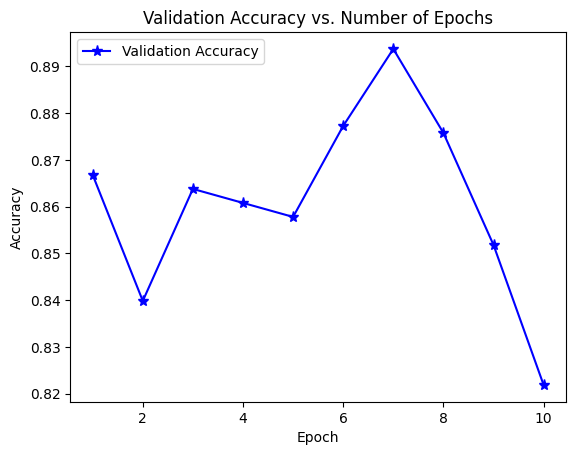

In [120]:
import matplotlib.pyplot as plt

def plot_val_accuracy(history):
    epochs = range(1, len(history["val_acc"]) + 1)
    val_acc = history["val_acc"]

    plt.figure(facecolor='white')  # White background
    plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy', marker='*', markersize=8)  # Star markers
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy vs. Number of Epochs')
    plt.legend()
    plt.show()

# Usage
plot_val_accuracy(history)


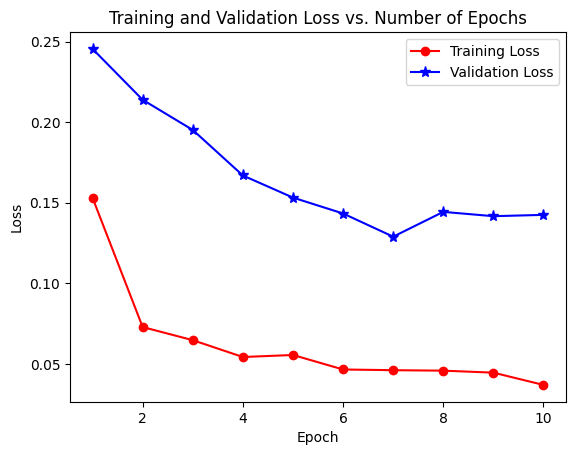

In [121]:
import matplotlib.pyplot as plt

def plot_losses(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(facecolor='white')  # White background
    plt.plot(epochs, history["train_loss"], 'r-o', label='Training Loss', markersize=6)
    plt.plot(epochs, history["val_loss"], 'b-*', label='Validation Loss', markersize=8)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Number of Epochs')
    plt.legend()
    plt.show()

# Usage
plot_losses(history)


In [122]:
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)
model.eval()  # important for inference


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [123]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def compute_metrics(labels, preds, probs):
    """Compute binary classification metrics safely."""
    return {
        'acc': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f1': f1_score(labels, preds, zero_division=0),
        'auc': roc_auc_score(labels, probs) if len(np.unique(labels)) > 1 else float('nan')
    }

def evaluate_model_on_test(model, test_loader, device, plot_roc=True):
    model = model.to(device)
    model.eval()

    test_labels, test_preds, test_probs = [], [], []
    test_loss, total_samples = 0.0, 0
    criterion = torch.nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            labels_np = labels.cpu().numpy().astype(int)

            test_labels.extend(labels_np.flatten())
            test_preds.extend(preds.flatten())
            test_probs.extend(probs.flatten())

    avg_loss = test_loss / total_samples
    metrics = compute_metrics(test_labels, test_preds, test_probs)

    print("\nTest Set Evaluation")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {metrics['acc']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")

    # Confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Pneumonia'], 
                yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC curve
    if plot_roc and len(np.unique(test_labels)) > 1:
        fpr, tpr, _ = roc_curve(test_labels, test_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
        plt.plot([0,1], [0,1], 'k--')  # diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    return metrics



Test Set Evaluation
Loss: 0.2167
Accuracy: 0.9197
Precision: 0.9745
Recall: 0.9160
F1-score: 0.9443
AUC: 0.9724


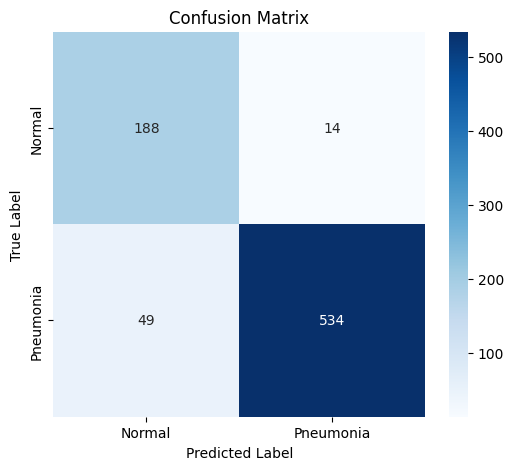

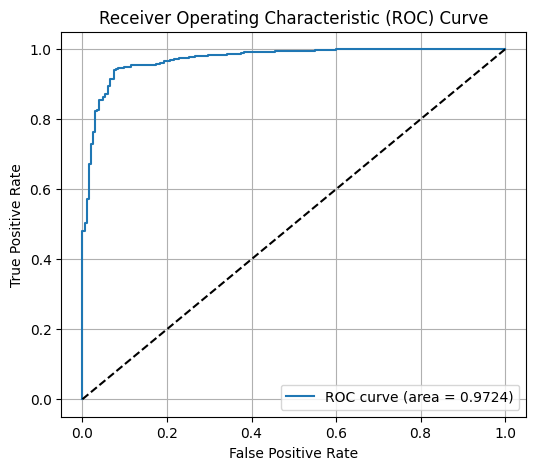

In [124]:
metrics = evaluate_model_on_test(model, test_loader, device)


In [131]:
import torch
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d(1)  # (128, 1, 1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)  # raw logits
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_model = CustomCNN().to(device)

custom_pos_weight = torch.tensor([0.35], dtype=torch.float).to(device)
custom_criterion = nn.BCEWithLogitsLoss(pos_weight=custom_pos_weight)
custom_optimizer = torch.optim.Adam(custom_model.parameters(), lr=1e-4)

print("Model & loss ready on", device)


Model & loss ready on cpu


In [133]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import torch

def compute_metrics(labels, preds, probs):
    """Compute binary classification metrics safely."""
    return {
        'acc': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f1': f1_score(labels, preds, zero_division=0),
        'auc': roc_auc_score(labels, probs) if len(set(labels)) > 1 else float('nan')
    }

def train_custom_model(custom_model, criterion, optimizer, train_loader, val_loader, device,
                       num_epochs=20, patience=5, best_model_path='best_custom_cnn.pth'):
    custom_model = custom_model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0

    history = {"train_loss": [], "val_loss": [],
               "train_acc": [], "val_acc": [],
               "train_precision": [], "val_precision": [],
               "train_recall": [], "val_recall": [],
               "train_f1": [], "val_f1": [],
               "train_auc": [], "val_auc": []}

    print(f"Training on device: {device}")
    print(f"Train size: {len(train_loader.dataset)} | Val size: {len(val_loader.dataset)}")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # --- Training ---
        custom_model.train()
        all_labels, all_preds, all_probs = [], [], []
        running_loss, total_samples = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = custom_model(inputs).view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            probs = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            labels_np = labels.detach().cpu().numpy().astype(int)

            all_labels.extend(labels_np.flatten())
            all_preds.extend(preds.flatten())
            all_probs.extend(probs.flatten())

        train_loss = running_loss / total_samples
        train_metrics = compute_metrics(all_labels, all_preds, all_probs)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_metrics['acc'])
        history["train_precision"].append(train_metrics['precision'])
        history["train_recall"].append(train_metrics['recall'])
        history["train_f1"].append(train_metrics['f1'])
        history["train_auc"].append(train_metrics['auc'])

        print(f"Train Loss: {train_loss:.4f} "
              f"Acc: {train_metrics['acc']:.4f} "
              f"Precision: {train_metrics['precision']:.4f} "
              f"Recall: {train_metrics['recall']:.4f} "
              f"F1: {train_metrics['f1']:.4f} "
              f"AUC: {train_metrics['auc']:.4f}")

        # --- Validation ---
        custom_model.eval()
        val_loss, val_samples = 0.0, 0
        val_labels, val_preds, val_probs = [], [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = custom_model(inputs).view(-1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_samples += inputs.size(0)

                probs = torch.sigmoid(outputs).cpu().numpy()
                preds = (probs >= 0.5).astype(int)
                labels_np = labels.cpu().numpy().astype(int)

                val_labels.extend(labels_np.flatten())
                val_preds.extend(preds.flatten())
                val_probs.extend(probs.flatten())

        val_epoch_loss = val_loss / val_samples
        val_metrics = compute_metrics(val_labels, val_preds, val_probs)

        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(val_metrics['acc'])
        history["val_precision"].append(val_metrics['precision'])
        history["val_recall"].append(val_metrics['recall'])
        history["val_f1"].append(val_metrics['f1'])
        history["val_auc"].append(val_metrics['auc'])

        print(f"Val Loss: {val_epoch_loss:.4f} "
              f"Acc: {val_metrics['acc']:.4f} "
              f"Precision: {val_metrics['precision']:.4f} "
              f"Recall: {val_metrics['recall']:.4f} "
              f"F1: {val_metrics['f1']:.4f} "
              f"AUC: {val_metrics['auc']:.4f}")

        # --- Early Stopping ---
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            patience_counter = 0
            torch.save(custom_model.state_dict(), best_model_path)
            print(f" Model saved at epoch {epoch+1} with val_loss = {val_epoch_loss:.4f}")
        else:
            patience_counter += 1
            print(f" No improvement. EarlyStopping counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    custom_model.load_state_dict(torch.load(best_model_path))
    print("Training Completed: Best CustomCNN reloaded from disk.")
    return custom_model, history


In [134]:
# Train custom CNN
trained_model, history = train_custom_model(
    custom_model=custom_model,
    criterion=custom_criterion,
    optimizer=custom_optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=20,
    patience=7,
    best_model_path="best_custom_cnn.pth"
)

# Save the current history 
custom_cnn_history = history

# Save custom CNN history to JSON file
save_history(custom_cnn_history, filename='custom_cnn_history.json')


Training on device: cpu
Train size: 3779 | Val size: 668

Epoch 1/20
Train Loss: 0.3385 Acc: 0.5531 Precision: 0.8734 Recall: 0.4650 F1: 0.6069 AUC: 0.7068
Val Loss: 0.3107 Acc: 0.7515 Precision: 0.8767 Recall: 0.7742 F1: 0.8223 AUC: 0.8200
 Model saved at epoch 1 with val_loss = 0.3107

Epoch 2/20
Train Loss: 0.3069 Acc: 0.7155 Precision: 0.8844 Recall: 0.7093 F1: 0.7873 AUC: 0.7788
Val Loss: 0.2845 Acc: 0.7620 Precision: 0.8532 Recall: 0.8206 F1: 0.8366 AUC: 0.8338
 Model saved at epoch 2 with val_loss = 0.2845

Epoch 3/20
Train Loss: 0.2820 Acc: 0.7367 Precision: 0.9109 Recall: 0.7150 F1: 0.8012 AUC: 0.8142
Val Loss: 0.2739 Acc: 0.7725 Precision: 0.8510 Recall: 0.8407 F1: 0.8458 AUC: 0.8369
 Model saved at epoch 3 with val_loss = 0.2739

Epoch 4/20
Train Loss: 0.2740 Acc: 0.7425 Precision: 0.9038 Recall: 0.7307 F1: 0.8081 AUC: 0.8183
Val Loss: 0.2771 Acc: 0.7799 Precision: 0.8375 Recall: 0.8730 F1: 0.8549 AUC: 0.8483
 No improvement. EarlyStopping counter: 1/7

Epoch 5/20
Train Loss

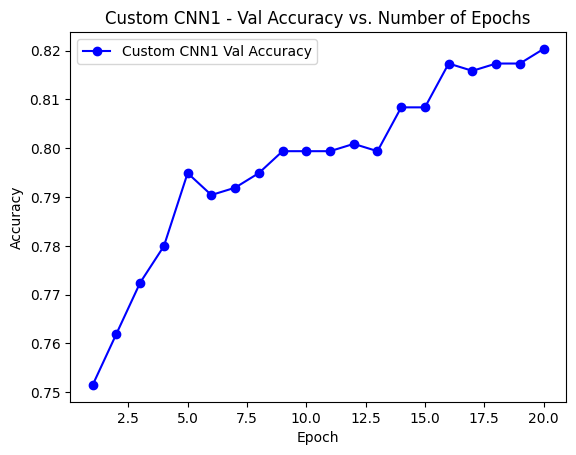

In [139]:
def plot_val_accuracy_custom(custom_cnn_history):
    epochs = range(1, len(custom_cnn_history["val_acc"]) + 1)
    val_acc = custom_cnn_history["val_acc"]

    plt.figure(facecolor='white')
    plt.plot(epochs, val_acc, 'b-', label='Custom CNN1 Val Accuracy', marker='o', markersize=6)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Custom CNN1 - Val Accuracy vs. Number of Epochs')
    plt.legend()
    plt.show()

# Usage
plot_val_accuracy_custom(custom_cnn_history)


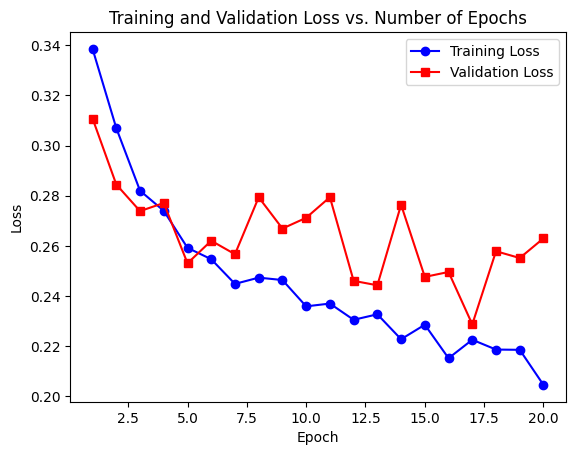

In [140]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    train_loss = history["train_loss"]
    val_loss = history["val_loss"]

    plt.figure(facecolor='white')
    plt.plot(epochs, train_loss, 'b-', label='Training Loss', marker='o', markersize=6)
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss', marker='s', markersize=6)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Number of Epochs')
    plt.legend()
    plt.show()

# Usage
plot_loss_curves(custom_cnn_history)


In [198]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, roc_curve, auc)

def compute_metrics(labels, preds, probs):
    """Compute binary classification metrics safely."""
    return {
        'acc': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f1': f1_score(labels, preds, zero_division=0),
        'auc': roc_auc_score(labels, probs) if len(np.unique(labels)) > 1 else float('nan')
    }

def evaluate_custom_cnn(model, test_loader, device, plot_roc=True):
    
    custom_model = model
    custom_model = custom_model.to(device)
    custom_model.eval()


    test_labels, test_preds, test_probs = [], [], []
    criterion = torch.nn.BCEWithLogitsLoss()
    test_loss, total_samples = 0.0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)  # shape: [batch, 1]

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            labels_np = labels.cpu().numpy().astype(int)

            test_labels.extend(labels_np.flatten())
            test_preds.extend(preds.flatten())
            test_probs.extend(probs.flatten())

    avg_loss = test_loss / total_samples
    metrics = compute_metrics(test_labels, test_preds, test_probs)

    # Print metrics
    print("\nCustom CNN1 Test Set Evaluation")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {metrics['acc']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")

    # Confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Pneumonia'], 
                yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Custom CNN1 Confusion Matrix')
    plt.show()

    # ROC curve
    if plot_roc and len(np.unique(test_labels)) > 1:
        fpr, tpr, _ = roc_curve(test_labels, test_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
        plt.plot([0,1], [0,1], 'k--')  # diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Custom CNN ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    return metrics



Custom CNN1 Test Set Evaluation
Loss: 0.3628
Accuracy: 0.8229
Precision: 0.8700
Recall: 0.8954
F1-score: 0.8825
AUC: 0.8910


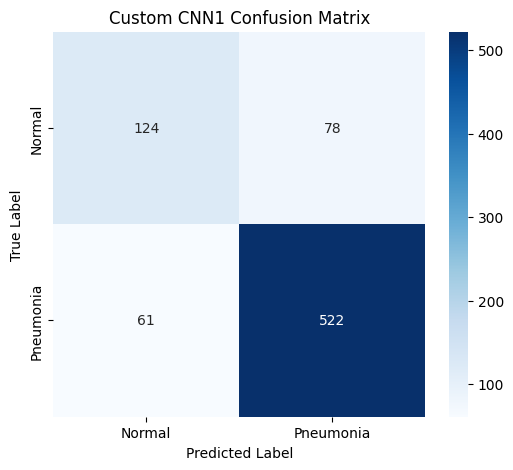

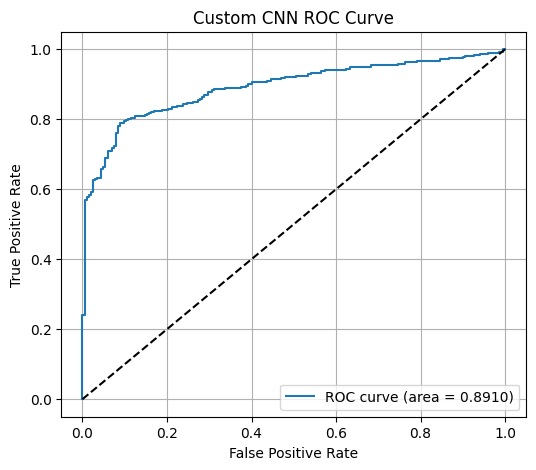

In [200]:
custom_cnn_metrics = evaluate_custom_cnn(custom_model, test_loader, device)


In [21]:
import os
import random
from PIL import Image
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms.functional as TF

# 1. Preprocessing

def preprocess_simple(img):
    img = img.convert('RGB')      # Ensure 3 channels
    img = img.resize((224, 224))  # Resize to model input size
    return img

# 2. Augmentation 

def augment_simple(img):
    # Horizontal flip with 50% probability
    if random.random() > 0.5:
        img = TF.hflip(img)

    # Random rotation between -10 and 10 degrees
    angle = random.uniform(-10, 10)
    img = TF.rotate(img, angle)

    return img

# 3. Custom Dataset Wrapper

class CustomImageFolder2(ImageFolder):
    def __init__(self, root, transform=None, augment=False):
        super().__init__(root)
        self.transform = transform
        self.augment = augment

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        # Preprocessing
        img = preprocess_simple(img)

        # Augmentation
        if self.augment:
            img = augment_simple(img)

        # Transform to tensor & normalize
        if self.transform is not None:
            img = self.transform(img)

        return img, target


# 4. Transform Pipeline

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


# 5. Dataset & Dataloader Setup

base_path = r'C:\Users\user\OneDrive - University of Hertfordshire\project\Dataset_splitted'

train_dataset_cnn2 = CustomImageFolder2(os.path.join(base_path, 'train'), transform=transform, augment=True)
val_dataset_cnn2   = CustomImageFolder2(os.path.join(base_path, 'val'), transform=transform, augment=False)
test_dataset_cnn2  = CustomImageFolder2(os.path.join(base_path, 'test'), transform=transform, augment=False)

train_loader_cnn2 = DataLoader(train_dataset_cnn2, batch_size=32, shuffle=True, num_workers=0)
val_loader_cnn2   = DataLoader(val_dataset_cnn2, batch_size=32, shuffle=False, num_workers=0)
test_loader_cnn2  = DataLoader(test_dataset_cnn2, batch_size=32, shuffle=False, num_workers=0)

# 6. Display Image Counts

print(f"Number of training images: {len(train_dataset_cnn2)}")
print(f"Number of validation images: {len(val_dataset_cnn2)}")
print(f"Number of test images: {len(test_dataset_cnn2)}")


Number of training images: 3779
Number of validation images: 668
Number of test images: 785


In [76]:
import torch
import torch.nn as nn


# Custom CNN2

class CustomCNN2(nn.Module):
    def __init__(self):
        super(CustomCNN2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d(1)  # (128, 1, 1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)  # raw logits
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Training setup for CustomCNN2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_model2 = CustomCNN2().to(device)

custom2_pos_weight = torch.tensor([0.35], dtype=torch.float).to(device)
custom2_criterion = nn.BCEWithLogitsLoss(pos_weight=custom2_pos_weight)
custom2_optimizer = torch.optim.Adam(custom_model2.parameters(), lr=1e-4)

print("CustomCNN2 model & loss ready on", device)


CustomCNN2 model & loss ready on cpu


In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def compute_metrics(labels, preds, probs):
    return {
        'acc': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f1': f1_score(labels, preds, zero_division=0),
        'auc': roc_auc_score(labels, probs) if len(set(labels)) > 1 else float('nan')
    }

# CustomCNN2 Training Function

def train_custom_model2(custom_model2, criterion, optimizer, train_loader_cnn2, val_loader_cnn2, device,
                        num_epochs=20, patience=7, best_model_path='best_custom_cnn2.pth'):
    custom_model2 = custom_model2.to(device)
    best_val_loss = float('inf')
    patience_counter = 0

    history = {"train_loss": [], "val_loss": [],
               "train_acc": [], "val_acc": [],
               "train_precision": [], "val_precision": [],
               "train_recall": [], "val_recall": [],
               "train_f1": [], "val_f1": [],
               "train_auc": [], "val_auc": []}

    print(f"Training on device: {device}")
    print(f"Train size: {len(train_loader_cnn2.dataset)} | Val size: {len(val_loader_cnn2.dataset)}")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # --- Training ---
        custom_model2.train()
        all_labels, all_preds, all_probs = [], [], []
        running_loss, total_samples = 0.0, 0

        for inputs, labels in train_loader_cnn2:
            inputs, labels = inputs.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = custom_model2(inputs).view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            probs = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            labels_np = labels.detach().cpu().numpy().astype(int)

            all_labels.extend(labels_np.flatten())
            all_preds.extend(preds.flatten())
            all_probs.extend(probs.flatten())

        train_loss = running_loss / total_samples
        train_metrics = compute_metrics(all_labels, all_preds, all_probs)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_metrics['acc'])
        history["train_precision"].append(train_metrics['precision'])
        history["train_recall"].append(train_metrics['recall'])
        history["train_f1"].append(train_metrics['f1'])
        history["train_auc"].append(train_metrics['auc'])

        print(f"Train Loss: {train_loss:.4f} "
              f"Acc: {train_metrics['acc']:.4f} "
              f"Precision: {train_metrics['precision']:.4f} "
              f"Recall: {train_metrics['recall']:.4f} "
              f"F1: {train_metrics['f1']:.4f} "
              f"AUC: {train_metrics['auc']:.4f}")

        # --- Validation ---
        custom_model2.eval()
        val_loss, val_samples = 0.0, 0
        val_labels, val_preds, val_probs = [], [], []

        with torch.no_grad():
            for inputs, labels in val_loader_cnn2:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = custom_model2(inputs).view(-1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_samples += inputs.size(0)

                probs = torch.sigmoid(outputs).cpu().numpy()
                preds = (probs >= 0.5).astype(int)
                labels_np = labels.cpu().numpy().astype(int)

                val_labels.extend(labels_np.flatten())
                val_preds.extend(preds.flatten())
                val_probs.extend(probs.flatten())

        val_epoch_loss = val_loss / val_samples
        val_metrics = compute_metrics(val_labels, val_preds, val_probs)

        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(val_metrics['acc'])
        history["val_precision"].append(val_metrics['precision'])
        history["val_recall"].append(val_metrics['recall'])
        history["val_f1"].append(val_metrics['f1'])
        history["val_auc"].append(val_metrics['auc'])

        print(f"Val Loss: {val_epoch_loss:.4f} "
              f"Acc: {val_metrics['acc']:.4f} "
              f"Precision: {val_metrics['precision']:.4f} "
              f"Recall: {val_metrics['recall']:.4f} "
              f"F1: {val_metrics['f1']:.4f} "
              f"AUC: {val_metrics['auc']:.4f}")

        # --- Early Stopping ---
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            patience_counter = 0
            torch.save(custom_model2.state_dict(), best_model_path)
            print(f" Model saved at epoch {epoch+1} with val_loss = {val_epoch_loss:.4f}")
        else:
            patience_counter += 1
            print(f" No improvement. EarlyStopping counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    custom_model2.load_state_dict(torch.load(best_model_path))
    print("Training Completed: Best CustomCNN2 reloaded from disk.")
    return custom_model2, history


In [151]:
trained_model2, history_cnn2 = train_custom_model2(
    custom_model2=custom_model2,
    criterion=custom2_criterion,
    optimizer=custom2_optimizer,
    train_loader_cnn2=train_loader_cnn2,
    val_loader_cnn2=val_loader_cnn2,
    device=device,
    num_epochs=20,
    patience=7,
    best_model_path="best_custom_cnn2.pth"
)

custom_cnn2_history = history_cnn2
save_history(custom_cnn2_history, filename='custom_cnn2_history.json')

Training on device: cpu
Train size: 3779 | Val size: 668

Epoch 1/20
Train Loss: 0.3308 Acc: 0.6068 Precision: 0.8698 Recall: 0.5528 F1: 0.6760 AUC: 0.7240
Val Loss: 0.2976 Acc: 0.8039 Precision: 0.8891 Recall: 0.8407 F1: 0.8642 AUC: 0.8603
 Model saved at epoch 1 with val_loss = 0.2976

Epoch 2/20
Train Loss: 0.2764 Acc: 0.7314 Precision: 0.9162 Recall: 0.7022 F1: 0.7951 AUC: 0.8370
Val Loss: 0.2451 Acc: 0.8263 Precision: 0.8942 Recall: 0.8690 F1: 0.8814 AUC: 0.8982
 Model saved at epoch 2 with val_loss = 0.2451

Epoch 3/20
Train Loss: 0.2357 Acc: 0.7941 Precision: 0.9318 Recall: 0.7796 F1: 0.8489 AUC: 0.8785
Val Loss: 0.2534 Acc: 0.8249 Precision: 0.8427 Recall: 0.9395 F1: 0.8885 AUC: 0.9112
 No improvement. EarlyStopping counter: 1/7

Epoch 4/20
Train Loss: 0.2252 Acc: 0.8034 Precision: 0.9380 Recall: 0.7871 F1: 0.8559 AUC: 0.8842
Val Loss: 0.2055 Acc: 0.8548 Precision: 0.9236 Recall: 0.8770 F1: 0.8997 AUC: 0.9184
 Model saved at epoch 4 with val_loss = 0.2055

Epoch 5/20
Train Loss

In [80]:
import torch
import json

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Initialize the CustomCNN2 model architecture
custom_model2 = CustomCNN2()  # Make sure CustomCNN2 class is already defined

# 2. Load the trained weights
custom_model2.load_state_dict(torch.load("best_custom_cnn2.pth", map_location=device))

# 3. Move model to device and set to evaluation mode
custom_model2 = custom_model2.to(device)
custom_model2.eval()

# 4. Load training history
with open("custom_cnn2_history.json", "r") as f:
    custom_cnn2_history = json.load(f)

print("CustomCNN2 model and history loaded.")


CustomCNN2 model and history loaded.


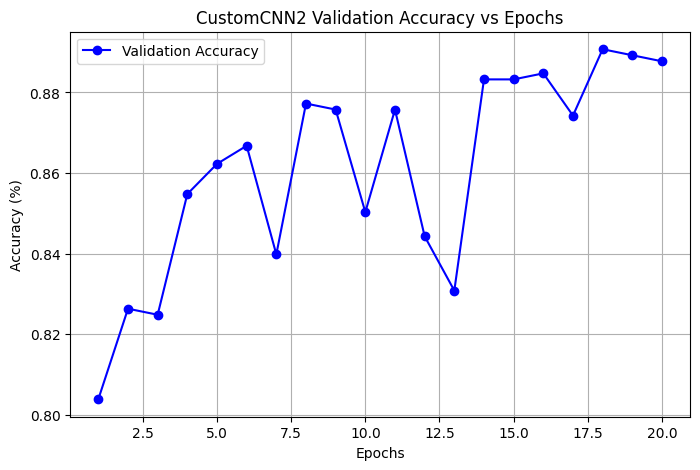

In [96]:
import json
import matplotlib.pyplot as plt

# Extract validation accuracy
val_acc = custom_cnn2_history.get("val_acc", None)

if val_acc is None:
    print("Validation accuracy not found in the history JSON.")
else:
    epochs = range(1, len(val_acc) + 1)
    
    plt.figure(figsize=(8,5))
    plt.plot(epochs, val_acc, 'b-o', label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("CustomCNN2 Validation Accuracy vs Epochs") 
    plt.grid(True)
    plt.legend()
    plt.show()


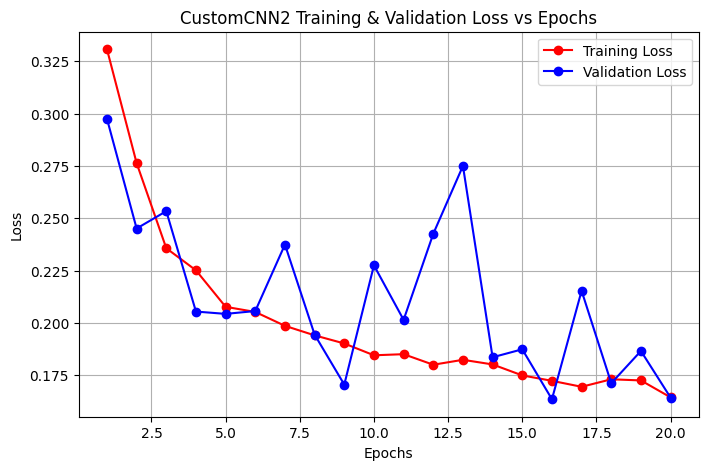

In [97]:
# Extract losses
train_loss = custom_cnn2_history.get("train_loss", None)
val_loss = custom_cnn2_history.get("val_loss", None)

if train_loss is None or val_loss is None:
    print("Training or validation loss not found in the history JSON.")
else:
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_loss, 'r-o', label='Training Loss')
    plt.plot(epochs, val_loss, 'b-o', label='Validation Loss')
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("CustomCNN2 Training & Validation Loss vs Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()



CustomCNN2 Model - Test Set Evaluation
Loss: 0.2654
Accuracy: 0.8879
Precision: 0.9381
Recall: 0.9091
F1-score: 0.9233
AUC: 0.9401


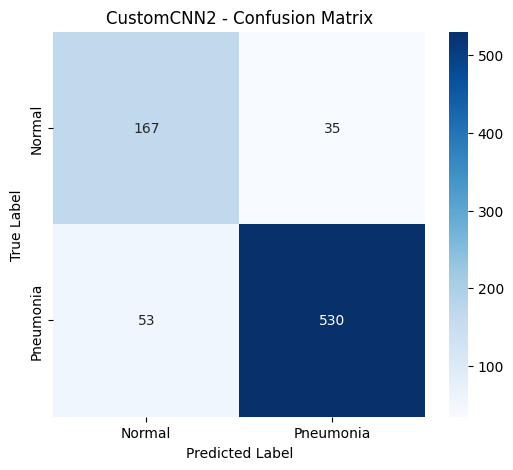

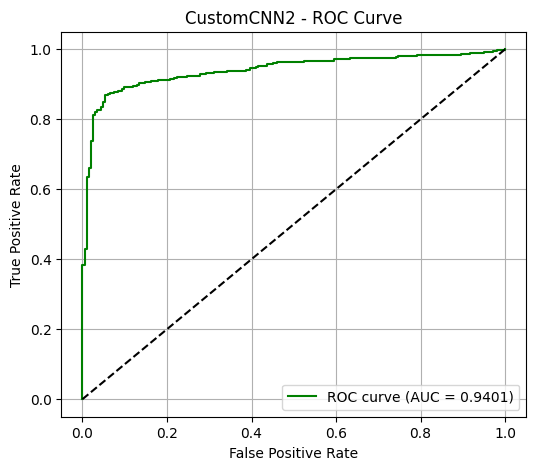

In [98]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute metrics
def compute_metrics(labels, preds, probs):
    return {
        'acc': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f1': f1_score(labels, preds, zero_division=0),
        'auc': roc_auc_score(labels, probs) if len(np.unique(labels)) > 1 else float('nan')
    }

# Evaluate CustomCNN2
def evaluate_custom_cnn2(test_loader, model, device, plot_roc=True):
    model = model.to(device)
    model.eval()

    test_labels, test_preds, test_probs = [], [], []
    test_loss, total_samples = 0.0, 0
    criterion = torch.nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            labels_np = labels.cpu().numpy().astype(int)

            test_labels.extend(labels_np.flatten())
            test_preds.extend(preds.flatten())
            test_probs.extend(probs.flatten())

    avg_loss = test_loss / total_samples
    metrics = compute_metrics(test_labels, test_preds, test_probs)

    print("\nCustomCNN2 Model - Test Set Evaluation")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {metrics['acc']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")

    # Confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Pneumonia'], 
                yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('CustomCNN2 - Confusion Matrix')
    plt.show()

    # ROC curve
    if plot_roc and len(np.unique(test_labels)) > 1:
        fpr, tpr, _ = roc_curve(test_labels, test_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', color='green')
        plt.plot([0,1], [0,1], 'k--')  # diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('CustomCNN2 - ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    return metrics

# Example usage
test_metrics_custom_cnn2 = evaluate_custom_cnn2(
    test_loader_cnn2, 
    custom_model2, 
    device=device
)


In [3]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet50
resnet50_normal = resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze all layers first
for param in resnet50_normal.parameters():
    param.requires_grad = False

# Replace final fully connected layer for binary classification
num_ftrs_normal = resnet50_normal.fc.in_features
resnet50_normal.fc = nn.Linear(num_ftrs_normal, 1)  # Output raw logits

# Unfreeze last convolutional block (layer4) and the final FC layer
for name, param in resnet50_normal.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

resnet50_normal = resnet50_normal.to(device)

# Define pos_weight for imbalanced dataset
pos_weight_normal = torch.tensor([0.35], dtype=torch.float).to(device)
criterion_normal = nn.BCEWithLogitsLoss(pos_weight=pos_weight_normal)

# Set optimizer to update only parameters that require gradients
optimizer_normal = torch.optim.Adam(
    filter(lambda p: p.requires_grad, resnet50_normal.parameters()), 
    lr=1e-4
)

print("Parameters to be trained (ResNet50 Normal):")
for name, param in resnet50_normal.named_parameters():
    if param.requires_grad:
        print(name)

# Count total and trainable parameters
total_params_normal = sum(p.numel() for p in resnet50_normal.parameters())
trainable_params_normal = sum(p.numel() for p in resnet50_normal.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params_normal:,} ({total_params_normal/1e6:.2f}M)")
print(f"Trainable parameters: {trainable_params_normal:,} ({trainable_params_normal/1e6:.2f}M)")


Parameters to be trained (ResNet50 Normal):
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.conv3.weight
layer4.0.bn3.weight
layer4.0.bn3.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
layer4.1.conv3.weight
layer4.1.bn3.weight
layer4.1.bn3.bias
layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
layer4.2.conv3.weight
layer4.2.bn3.weight
layer4.2.bn3.bias
fc.weight
fc.bias

Total parameters: 23,510,081 (23.51M)
Trainable parameters: 14,966,785 (14.97M)


In [7]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import json

# Compute metrics
def compute_metrics(labels, preds, probs):
    return {
        'acc': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f1': f1_score(labels, preds, zero_division=0),
        'auc': roc_auc_score(labels, probs) if len(set(labels)) > 1 else float('nan')
    }

# Save history as JSON
def save_history(history, filename='history.json'):
    with open(filename, 'w') as f:
        json.dump(history, f, indent=4)

# Training function
def train_resnet50_normal_with_metrics_and_early_stopping(
    resnet50_normal, criterion_normal, optimizer_normal,train_loader_cnn2,val_loader_cnn2,
    device, num_epochs=10, patience=5, best_model_path='best_resnet50_normal.pth', debug=False
):
    resnet50_normal = resnet50_normal.to(device)
    best_val_loss = float('inf')
    patience_counter = 0

    history_normal_resnet = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": [],
        "train_precision": [], "val_precision": [],
        "train_recall": [], "val_recall": [],
        "train_f1": [], "val_f1": [],
        "train_auc": [], "val_auc": []
    }

    print(f"resnet50_normal_model")
    print(f"Training on device: {device}")
    print(f"Train size: {len(train_loader_cnn2.dataset)} | Val size: {len(val_loader_cnn2.dataset)}")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # -------- Training --------
        resnet50_normal.train()
        all_labels, all_preds, all_probs = [], [], []
        running_loss, total_samples = 0.0, 0

        for inputs, labels in train_loader_cnn2:  # <- using your normal train loader
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            optimizer_normal.zero_grad()
            outputs = resnet50_normal(inputs)
            loss = criterion_normal(outputs, labels)
            loss.backward()
            optimizer_normal.step()

            running_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            probs = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            labels_np = labels.detach().cpu().numpy().astype(int)

            all_labels.extend(labels_np.flatten())
            all_preds.extend(preds.flatten())
            all_probs.extend(probs.flatten())

        train_loss = running_loss / total_samples
        train_metrics = compute_metrics(all_labels, all_preds, all_probs)

        # Update history
        history_normal_resnet["train_loss"].append(train_loss)
        history_normal_resnet["train_acc"].append(train_metrics['acc'])
        history_normal_resnet["train_precision"].append(train_metrics['precision'])
        history_normal_resnet["train_recall"].append(train_metrics['recall'])
        history_normal_resnet["train_f1"].append(train_metrics['f1'])
        history_normal_resnet["train_auc"].append(train_metrics['auc'])

        print(f"Train Loss: {train_loss:.4f} "
              f"Acc: {train_metrics['acc']:.4f} "
              f"Precision: {train_metrics['precision']:.4f} "
              f"Recall: {train_metrics['recall']:.4f} "
              f"F1: {train_metrics['f1']:.4f} "
              f"AUC: {train_metrics['auc']:.4f}")

        # -------- Validation --------
        resnet50_normal.eval()
        val_loss, val_samples = 0.0, 0
        val_labels, val_preds, val_probs = [], [], []

        with torch.no_grad():
            for inputs, labels in val_loader_cnn2:  # <- using your normal val loader
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)

                outputs = resnet50_normal(inputs)
                loss = criterion_normal(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_samples += inputs.size(0)

                probs = torch.sigmoid(outputs).cpu().numpy()
                preds = (probs >= 0.5).astype(int)
                labels_np = labels.cpu().numpy().astype(int)

                val_labels.extend(labels_np.flatten())
                val_preds.extend(preds.flatten())
                val_probs.extend(probs.flatten())

        val_epoch_loss = val_loss / val_samples
        val_metrics = compute_metrics(val_labels, val_preds, val_probs)

        # Update history
        history_normal_resnet["val_loss"].append(val_epoch_loss)
        history_normal_resnet["val_acc"].append(val_metrics['acc'])
        history_normal_resnet["val_precision"].append(val_metrics['precision'])
        history_normal_resnet["val_recall"].append(val_metrics['recall'])
        history_normal_resnet["val_f1"].append(val_metrics['f1'])
        history_normal_resnet["val_auc"].append(val_metrics['auc'])

        print(f"Val Loss: {val_epoch_loss:.4f} "
              f"Acc: {val_metrics['acc']:.4f} "
              f"Precision: {val_metrics['precision']:.4f} "
              f"Recall: {val_metrics['recall']:.4f} "
              f"F1: {val_metrics['f1']:.4f} "
              f"AUC: {val_metrics['auc']:.4f}")

        # -------- Early Stopping --------
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            patience_counter = 0
            torch.save(resnet50_normal.state_dict(), best_model_path)
            print(f" Model saved at epoch {epoch+1} with val_loss = {val_epoch_loss:.4f}")
        else:
            patience_counter += 1
            print(f" No improvement. Counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Reload best model
    resnet50_normal.load_state_dict(torch.load(best_model_path))
    print("Training complete. Best model reloaded from disk.")

    # Save history as JSON
    save_history(history_normal_resnet, filename='resnet50_normal_history.json')

    return resnet50_normal, history_normal_resnet


In [183]:
trained_resnet50_normal, history_normal_resnet = train_resnet50_normal_with_metrics_and_early_stopping(
    resnet50_normal,
    criterion_normal,
    optimizer_normal,
    train_loader_cnn2,  
    val_loader_cnn2,    
    device=device,
    num_epochs=10,
    patience=5,
    best_model_path="best_resnet50_normal.pth"
)


resnet50_normal_model
Training on device: cpu
Train size: 3779 | Val size: 668

Epoch 1/10
Train Loss: 0.1380 Acc: 0.9140 Precision: 0.9708 Recall: 0.9116 F1: 0.9402 AUC: 0.9691
Val Loss: 0.0809 Acc: 0.9371 Precision: 0.9892 Recall: 0.9254 F1: 0.9563 AUC: 0.9871
 Model saved at epoch 1 with val_loss = 0.0809

Epoch 2/10
Train Loss: 0.0577 Acc: 0.9606 Precision: 0.9882 Recall: 0.9583 F1: 0.9730 AUC: 0.9921
Val Loss: 0.0595 Acc: 0.9506 Precision: 0.9915 Recall: 0.9415 F1: 0.9659 AUC: 0.9923
 Model saved at epoch 2 with val_loss = 0.0595

Epoch 3/10
Train Loss: 0.0397 Acc: 0.9714 Precision: 0.9923 Recall: 0.9690 F1: 0.9805 AUC: 0.9964
Val Loss: 0.0593 Acc: 0.9506 Precision: 0.9894 Recall: 0.9435 F1: 0.9659 AUC: 0.9927
 Model saved at epoch 3 with val_loss = 0.0593

Epoch 4/10
Train Loss: 0.0363 Acc: 0.9749 Precision: 0.9920 Recall: 0.9740 F1: 0.9829 AUC: 0.9968
Val Loss: 0.0495 Acc: 0.9656 Precision: 0.9876 Recall: 0.9657 F1: 0.9766 AUC: 0.9943
 Model saved at epoch 4 with val_loss = 0.04

In [4]:
import torch
import torchvision.models as models
from torchvision import transforms

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Define the ResNet50 model for binary classification
resnet50_normal = models.resnet50(pretrained=False)
resnet50_normal.fc = torch.nn.Linear(resnet50_normal.fc.in_features, 1)  # binary output

# 2. Load the trained weights
resnet50_normal.load_state_dict(torch.load("best_resnet50_normal.pth", map_location=device))

# 3. Move model to device and set to evaluation mode
resnet50_normal = resnet50_normal.to(device)
resnet50_normal.eval()

import json

# Load training history
with open("resnet50_normal_history.json", "r") as f:
    history_normal_resnet = json.load(f)

print("ResNet50 Normal model and history loaded.")


ResNet50 Normal model and history loaded.


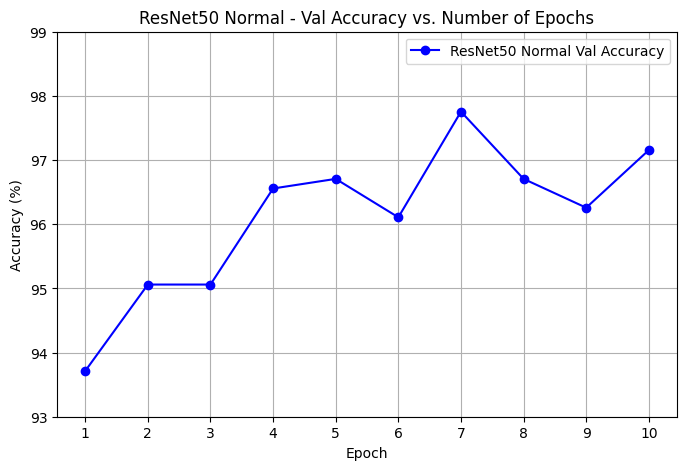

In [17]:
import matplotlib.pyplot as plt

def plot_val_accuracy_resnet_normal(history_normal_resnet):
    epochs = range(1, len(history_normal_resnet["val_acc"]) + 1)
    val_acc = [acc * 100 for acc in history_normal_resnet["val_acc"]]  # convert to percentage

    plt.figure(facecolor='white', figsize=(8,5))
    plt.plot(epochs, val_acc, 'b-', label='ResNet50 Normal Val Accuracy', marker='o', markersize=6)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('ResNet50 Normal - Val Accuracy vs. Number of Epochs')
    plt.xticks(epochs)
    plt.ylim(93, 99)  
    plt.grid(True)
    plt.legend()
    plt.show()

# Usage
plot_val_accuracy_resnet_normal(history_normal_resnet)


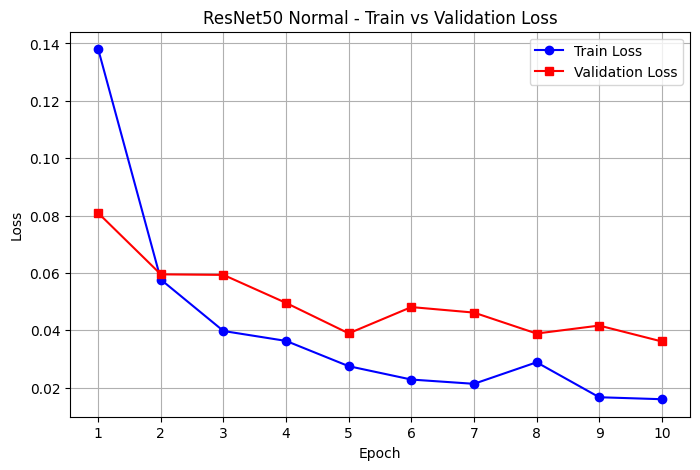

In [18]:
import matplotlib.pyplot as plt

def plot_loss_resnet_normal(history_normal_resnet):
    epochs = range(1, len(history_normal_resnet["train_loss"]) + 1)
    train_loss = history_normal_resnet["train_loss"]
    val_loss = history_normal_resnet["val_loss"]

    plt.figure(facecolor='white', figsize=(8,5))
    plt.plot(epochs, train_loss, 'b-o', label='Train Loss', markersize=6)
    plt.plot(epochs, val_loss, 'r-s', label='Validation Loss', markersize=6)
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('ResNet50 Normal - Train vs Validation Loss')
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()
    plt.show()

# Usage
plot_loss_resnet_normal(history_normal_resnet)



ResNet50 Normal Model - Test Set Evaluation
Loss: 0.0629
Accuracy: 0.9809
Precision: 0.9982
Recall: 0.9760
F1-score: 0.9870
AUC: 0.9984


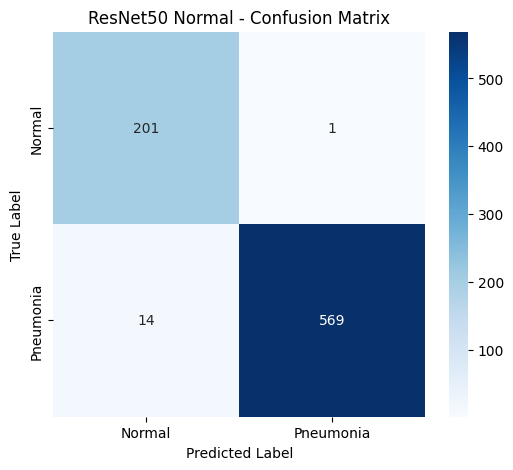

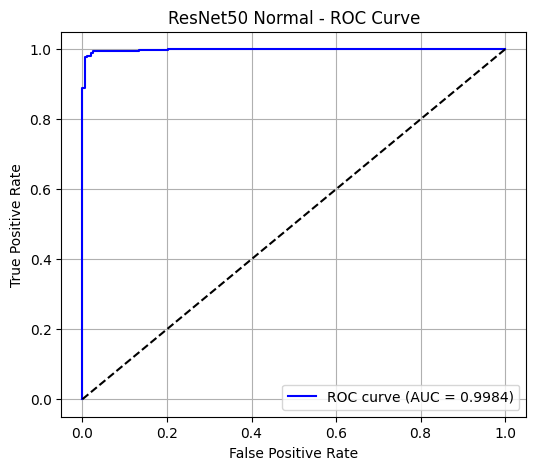

In [22]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute metrics
def compute_metrics(labels, preds, probs):
    return {
        'acc': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f1': f1_score(labels, preds, zero_division=0),
        'auc': roc_auc_score(labels, probs) if len(np.unique(labels)) > 1 else float('nan')
    }

# Evaluate ResNet50 Normal
def evaluate_resnet50_normal(test_loader_cnn2, model, device, plot_roc=True):
    # Use the separate model variable
    resnet50_normal = model
    resnet50_normal = resnet50_normal.to(device)
    resnet50_normal.eval()

    test_labels, test_preds, test_probs = [], [], []
    test_loss, total_samples = 0.0, 0
    criterion = torch.nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for inputs, labels in test_loader_cnn2:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = resnet50_normal(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            labels_np = labels.cpu().numpy().astype(int)

            test_labels.extend(labels_np.flatten())
            test_preds.extend(preds.flatten())
            test_probs.extend(probs.flatten())

    avg_loss = test_loss / total_samples
    metrics = compute_metrics(test_labels, test_preds, test_probs)

    print("\nResNet50 Normal Model - Test Set Evaluation")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {metrics['acc']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")

    # Confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Pneumonia'], 
                yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('ResNet50 Normal - Confusion Matrix')
    plt.show()

    # ROC curve
    if plot_roc and len(np.unique(test_labels)) > 1:
        fpr, tpr, _ = roc_curve(test_labels, test_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', color='blue')
        plt.plot([0,1], [0,1], 'k--')  # diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ResNet50 Normal - ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    return metrics

test_metrics_resnet_normal = evaluate_resnet50_normal(
    test_loader_cnn2, 
    resnet50_normal, 
    device=device
)


Predicted: Pneumonia (probability: 0.9997)


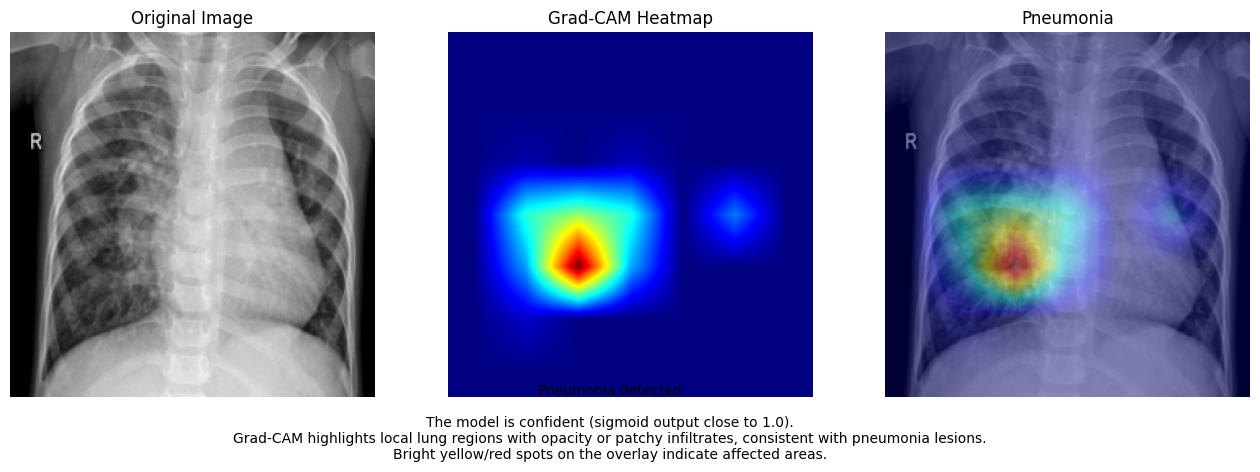

In [5]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Grad-CAM helper class (binary-safe)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output.detach()

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, target_class=None):
        output = self.model(input_tensor)
        self.model.zero_grad()

        # Binary classification
        if output.shape[1] == 1:
            if target_class is None:
                target_class = 1
            loss = output[0, 0] if target_class == 1 else -output[0, 0]
        else:
            if target_class is None:
                target_class = output.argmax(dim=1).item()
            loss = output[0, target_class]

        loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)

        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# Prediction + Grad-CAM visualization with explanation
def predict_with_gradcam_resnet50_normal(model, image_path, device, transform):
    # Load & preprocess
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    tensor_img = transform(img).unsqueeze(0).to(device)

    model = model.to(device)
    model.eval()

    with torch.no_grad():
        output = model(tensor_img)
        prob = torch.sigmoid(output).item()
        pred = 1 if prob >= 0.5 else 0

    classes = {0: 'Normal', 1: 'Pneumonia'}
    warning = " (LOW CONFIDENCE)" if 0.4 <= prob <= 0.6 else ""
    print(f"Predicted: {classes[pred]} (probability: {prob:.4f}){warning}")

    # Grad-CAM
    target_layer = model.layer4[1].conv3
    gradcam = GradCAM(model, target_layer)
    cam = gradcam.generate(tensor_img, target_class=pred)

    # Invert CAM so that high influence = blue
    cam_inverted = 1 - cam
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_inverted), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    original_img = np.array(img) / 255.0
    overlay = heatmap * 0.4 + original_img * 0.6

    original_img = np.clip(original_img, 0, 1)
    heatmap = np.clip(heatmap, 0, 1)
    overlay = np.clip(overlay, 0, 1)

    # Explanation text
    if pred == 1:  # Pneumonia
        explanation = (
            "Pneumonia detected\n\n"
            "The model is confident (sigmoid output close to 1.0).\n"
            "Grad-CAM highlights local lung regions with opacity or patchy infiltrates, "
            "consistent with pneumonia lesions.\n"
            "Bright yellow/red spots on the overlay indicate affected areas."
        )
    else:  # Normal
        explanation = (
            "Normal X-ray detected\n\n"
            "The model is confident (sigmoid output close to 0.0).\n"
            "Grad-CAM highlights diffuse or structural regions. such as ribs, diaphragm, or broad lung areas.\n"
            "No localized pneumonia patterns are detected."
        )

    # Plot original, heatmap, Grad-CAM + explanation
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))

    axs[0].imshow(original_img)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(heatmap)
    axs[1].set_title("Grad-CAM Heatmap")
    axs[1].axis('off')

    axs[2].imshow(overlay)
    axs[2].set_title(f"{classes[pred]}{warning}")
    axs[2].axis('off')
    
    # Add explanation below overlay image
    plt.figtext(0.5,0.01, explanation, wrap=True, horizontalalignment='center', fontsize=10)

    plt.show()

    return pred, prob, cam

# Transform for tensor conversion
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Example usage
image_path = r"C:\Users\user\OneDrive - University of Hertfordshire\project\Dataset_splitted\test\PNEUMONIA\BACTERIA-215369-0009.jpeg"
pred, prob, cam = predict_with_gradcam_resnet50_normal(resnet50_normal, image_path, device, transform)
